### Imports

In [1]:
import os
from os import listdir
from os.path import isfile, join

from PIL import Image

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
#import tensorflow as tf


### Image folder

In [2]:
image_dir = os.environ['IMAGES_FOLDER']
print(image_dir)

/Users/svinchon/code/NMenacho/To-infinity-and-beyond/data/images_cropped_sample


### Image folder to X,y

In [8]:
image_files = []
for f in listdir(image_dir):
    if isfile(os.path.join(image_dir, f)):
        if f.endswith(".jpg"):
            image_files.append(f)
        else:
            print("not jpg ignored")

X_list = []
y_list = []

for image_file in image_files:
    image_info = image_file.replace('.jpg', '').split("_")
    if len(image_info) > 4:
        cat = image_info[3]
        image_data = np.array(Image.open(os.path.join(image_dir,image_file)))
        X_list.append(image_data)
        y_list.append(cat)
    # else:
    #     os.remove(os.path.join(image_dir,image_file))

X_data = np.array(X_list)
print(X_data.shape)
y_data = np.array(y_list)
print(y_data.shape)

(4842, 128, 128, 3)
(4842,)


### View one image

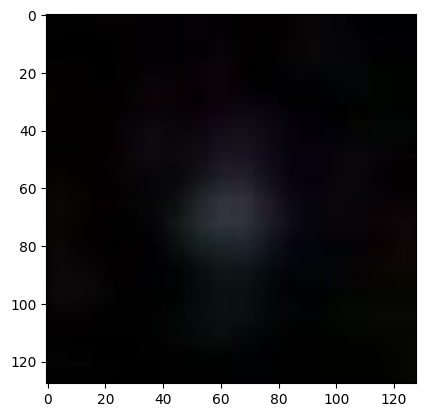

In [9]:
plt.imshow(X_data[3]) #/ use this tomorrow

### Check percentages

In [10]:
#y.value_counts()/len(y)

### Adjust y

In [11]:
import pandas as pd
y_data_cat = pd.Series(y_data).map({'STAR':0, 'GALAXY':1})
y_data_cat


0       1
1       0
2       1
3       0
4       0
       ..
4837    0
4838    0
4839    0
4840    1
4841    0
Length: 4842, dtype: int64

### Train/test split

In [12]:
X = X_data
y = y_data_cat

#y_cat = to_categorical(y, num_classes=2)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3873, 128, 128, 3), (969, 128, 128, 3), (3873,), (969,))

### Model

In [14]:
# model_1 from NAT' notebook
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Flatten(),
    Dense(10, activation='relu'),
    Dense(1, activation='sigmoid')
])

/Users/svinchon/.pyenv/versions/3.10.6/envs/to_infinity_and_beyond/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Model summary

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 62, 62, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 61504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       615,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,453 (2.42 MB)

 Trainable params: 634,453 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

### Model compilation

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        'recall',
        'precision',
        'mae',
        'mse'
    ]
)

### Model training

In [19]:
es = EarlyStopping(patience=5)

history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=100,
    validation_split=0.2,
    callbacks=[es]
)

Epoch 1/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3748 - loss: 0.0000e+00 - mae: 0.6252 - mse: 0.6252 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4065 - val_loss: 0.0000e+00 - val_mae: 0.5935 - val_mse: 0.5935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3952 - loss: 0.0000e+00 - mae: 0.6048 - mse: 0.6048 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4065 - val_loss: 0.0000e+00 - val_mae: 0.5935 - val_mse: 0.5935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - accuracy: 0.3973 - loss: 0.0000e+00 - mae: 0.6027 - mse: 0.6027 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.4065 - val_loss: 0.0000e+00 - val_mae: 0.5935 - val_mse: 0.5935 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/100
194/194 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3911 - loss: 0.0000e+00 - mae: 0

### Model evaluation

In [41]:
model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9339 - loss: 0.2045 - mae: 0.1287 - mse: 0.0530 - precision: 0.9339 - recall: 0.9339


[0.19500991702079773,
 0.945891797542572,
 0.945891797542572,
 0.945891797542572,
 0.12644706666469574,
 0.05031091347336769]